In [266]:
import os
import numpy as np
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy
import math

In [267]:
class Camera_pose:
    def __init__(self):
        self.name = ""
        self.position = [0, 0, 0]
        self.rotation = [0, 0, 0]

In [268]:
def rotation():
    xyz_mat = [0, 0, 0]
    roll = 90 # x
    pitch = 0 # y
    yaw = 0 # z

    # roll rotate x, pitch rotate y, yaw rotate z
    roll_mat = np.array([[1, 0, 0],
                        [0, math.cos(roll), -(math.sin(roll))],
                        [0, math.sin(roll), math.cos(roll)]
                        ])
    pitch_mat = np.array([[math.cos(pitch), 0, -(math.sin(pitch))],
                        [0, 1, 0],
                        [math.sin(pitch), 0, math.cos(pitch)]
                        ])
    yaw_mat = np.array([[math.cos(yaw), -(math.sin(yaw)), 0],
                        [math.sin(yaw), math.cos(yaw), 0],
                        [0, 0, 1]
                        ])
    rotation_mat = np.dot(np.dot(yaw_mat, pitch_mat), roll_mat)
    result_mat = np.dot(rotation_mat, xyz_mat)
    print(result_mat)

In [269]:
def euler_angles_to_directional_vector(x, y, z, row, pitch, yaw):
    # math cos() and sin() have to insert in unit 'rad'
    # rad = degree * math.pi / 180
    x_dir = math.cos(yaw*math.pi/180)*math.cos(pitch*math.pi/180)
    y_dir = math.sin(yaw*math.pi/180)*math.cos(pitch*math.pi/180)
    z_dir = math.sin(pitch*math.pi/180)
    # print(f'{x_dir}, {y_dir}, {z_dir}')
    return x, y, z, round(x_dir, 4), round(y_dir, 4), round(z_dir, 4)

In [270]:
def project(position, L):
    x, y, z, x_dir, y_dir, z_dir = euler_angles_to_directional_vector(
        position[0], position[1], position[2], position[3], position[4], position[5])
    print(f'x_dir:{x_dir}')
    print(f'y_dir:{y_dir}')
    print(f'z_dir:{z_dir}')
    D = ((L-x)/x_dir)
    new_x = L
    new_y = y + y_dir*D
    new_z = z + z_dir*D
    print(f"({new_x},{new_y},{new_z})")
    return new_x, new_y, new_z


In [271]:
def plot_heatmap():
    camera_positions = ['6x6', '9x4', '12x3', '18x2']
    scene = 'ArchVizInterior'
    QP = 20
    synthesizer = 'AdditiveSynthesizer'
    pose_traces = np.array([f'pose{i}' for i in range(10)])

    for pose_trace in pose_traces:
        print(f'{pose_trace}')
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        i = 0
        for camera_position in camera_positions:
            # pose_trace
            df = pd.DataFrame()
            df_tmp = pd.DataFrame()
            df_pose = pd.DataFrame()

            df_tmp = pd.read_csv(f'./project_results/all_pose_trace.csv')
            df = df.append(df_tmp)
            df_pose = df.loc[(df['pose_traces'] == pose_trace)]
            df_pose.reset_index(inplace=True, drop=True)

            # quality metrics
            df_psnr = pd.DataFrame()
            df_psnr = pd.read_csv(f'./psnr/{synthesizer}/{camera_position}_{scene}_rec{QP}_{synthesizer}_{pose_trace}_psnr.csv')

            # heatmap
            df_heatmap = pd.DataFrame()
            df_heatmap = pd.DataFrame(0, index=np.arange(-15, 16, 1), columns=np.arange(-15, 16, 1))
            for index in df_pose.index:
                x = round(df_pose['z'][index], 0)
                y = round(df_pose['y'][index], 0)
                v = df_psnr['vmaf'].values[index]
                if df_heatmap[x][y] < v:
                    df_heatmap.loc[x, y] = v
            i = i + 1
            ax = fig.add_subplot(2, 2, i)
            sns.heatmap(data=df_heatmap, vmax=100, vmin=0, ax=ax).set_title(f'{camera_position}')
            ax.invert_yaxis()
        # plt.savefig(f'./img/pose_trace_heatmap/{pose_trace}_in_{scene}.eps', dpi=300)
        plt.savefig(f'./img/pose_trace_heatmap/{pose_trace}_in_{scene}.png', dpi=300)
        plt.show()


    # # 0.5 each step
    # camera_positions = ['6x6', '9x4', '12x3', '18x2']
    # scene = 'ArchVizInterior'
    # QP = 20
    # synthesizer = 'AdditiveSynthesizer'
    # pose_trace = 'pose0'

    # for camera_position in camera_positions:
    #     # pose_trace
    #     df = pd.DataFrame()
    #     df_tmp = pd.DataFrame()
    #     df_pose = pd.DataFrame()

    #     df_tmp = pd.read_csv(f'./project_results/all_pose_trace.csv')
    #     df = df.append(df_tmp)
    #     df_pose = df.loc[(df['pose_traces'] == pose_trace)]

    #     # quality metrics
    #     df_psnr = pd.DataFrame()
    #     df_psnr = pd.read_csv(f'./psnr/{synthesizer}/{camera_position}_{scene}_rec{QP}_{synthesizer}_{pose_trace}_psnr.csv')

    #     # heatmap
    #     df_heatmap = pd.DataFrame()
    #     df_heatmap = pd.DataFrame(0, index=np.arange(-15, 15.5, 0.5), columns=np.arange(-15, 15.5, 0.5))
    #     for index in df_pose.index:
    #         x = round(0.5*round(df_pose['z'][index]/0.5), 1)
    #         y = round(0.5*round(df_pose['y'][index]/0.5), 1)
    #         v = df_psnr['vmaf'].values[index]
    #         if df_heatmap[x][y] < v:
    #             df_heatmap.loc[x, y] = v
        
    #     df_heatmap.to_csv(f'{camera_position}.csv')

    #     ax = sns.heatmap(data=df_heatmap, vmax=90, vmin=20)
    #     ax.invert_yaxis()
    #     plt.show()


In [272]:
def plot_heatmap_all():
    camera_positions = ['6x6', '9x4', '12x3', '18x2']
    scene = 'ArchVizInterior'
    QP = 20
    synthesizer = 'AdditiveSynthesizer'
    pose_traces = np.array([f'pose{i}' for i in range(10)])

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    i = 0
    for camera_position in camera_positions:
        # pose_trace
        df = pd.DataFrame()
        df_tmp = pd.DataFrame()
        df_pose = pd.DataFrame()

        df_tmp = pd.read_csv(f'./project_results/all_pose_trace.csv')
        df_pose = df.append(df_tmp)
        # df_pose = df.loc[(df['pose_traces'] == pose_trace)]
        df_pose.reset_index(inplace=True, drop=True)
        
        # quality metrics
        df_psnr = pd.DataFrame()
        for pose_trace in pose_traces:
            df_psnr_tmp = pd.read_csv(f'./psnr/{synthesizer}/{camera_position}_{scene}_rec{QP}_{synthesizer}_{pose_trace}_psnr.csv')
            df_psnr = df_psnr.append(df_psnr_tmp, ignore_index=True)
        
        # heatmap
        df_heatmap = pd.DataFrame()
        df_heatmap = pd.DataFrame(0, index=np.arange(-15, 16, 1), columns=np.arange(-15, 16, 1))
        for index in df_pose.index:
            x = round(df_pose['z'][index], 0)
            y = round(df_pose['y'][index], 0)
            v = df_psnr['vmaf'].values[index]
            if df_heatmap[x][y] < v:
                df_heatmap.loc[x, y] = v
        i = i + 1
        ax = fig.add_subplot(2, 2, i)
        sns.heatmap(data=df_heatmap, vmax=100, vmin=0, ax=ax).set_title(f'{camera_position}')
        ax.invert_yaxis()
    # plt.savefig(f'./img/pose_trace_heatmap/all_in_{scene}.eps', dpi=300)
    plt.savefig(f'./img/pose_trace_heatmap/all_in_{scene}.png', dpi=300)
    plt.show()

In [273]:
def plot_heatmap_all_diff():
    camera_positions = ['6x6', '9x4', '12x3', '18x2']
    scene = 'ArchVizInterior'
    QP = 20
    synthesizer = 'AdditiveSynthesizer'
    pose_traces = np.array([f'pose{i}' for i in range(10)])
    
    baseline = pd.DataFrame()

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    i = 0

    for camera_position in camera_positions:
        # pose_trace
        df = pd.DataFrame()
        df_tmp = pd.DataFrame()
        df_pose = pd.DataFrame()

        df_tmp = pd.read_csv(f'./project_results/all_pose_trace.csv')
        df_pose = df.append(df_tmp)
        # df_pose = df.loc[(df['pose_traces'] == pose_trace)]
        df_pose.reset_index(inplace=True, drop=True)
        
        # quality metrics
        df_psnr = pd.DataFrame()
        for pose_trace in pose_traces:
            df_psnr_tmp = pd.read_csv(f'./psnr/{synthesizer}/{camera_position}_{scene}_rec{QP}_{synthesizer}_{pose_trace}_psnr.csv')
            df_psnr = df_psnr.append(df_psnr_tmp, ignore_index=True)
        
        # heatmap
        df_heatmap = pd.DataFrame()
        df_heatmap = pd.DataFrame(0, index=np.arange(-15, 16, 1), columns=np.arange(-15, 16, 1))
        for index in df_pose.index:
            x = round(df_pose['z'][index], 0)
            y = round(df_pose['y'][index], 0)
            v = df_psnr['vmaf'].values[index]
            if df_heatmap[x][y] < v:
                df_heatmap.loc[x, y] = v
        i = i + 1
        ax = fig.add_subplot(2, 2, i)
        if i == 1:
            baseline = df_heatmap
            sns.heatmap(data=df_heatmap, vmax=100, vmin=0, ax=ax).set_title(f'{camera_position}')
            ax.invert_yaxis()
        else:
            df_heatmap = df_heatmap.sub(baseline)
            sns.heatmap(data=df_heatmap, ax=ax, center=0, vmax=60, vmin=-60, cmap=plt.cm.RdBu).set_title(f'{camera_position}')
            ax.invert_yaxis()
    # plt.savefig(f'./img/pose_trace_heatmap/diff_all_in_{scene}_baseline{scene[0]}.eps', dpi=300)
    plt.savefig(f'./img/pose_trace_heatmap/diff_all_in_{scene}_baseline{scene[0]}.png', dpi=300)
    plt.show()

In [274]:
def distance_to_center():
    pose_traces = np.array([f'pose{i}' for i in range(10)])

    df = pd.DataFrame()
    df_tmp = pd.read_csv(f'./project_results/all_pose_trace.csv')
    df = df.append(df_tmp)
    max_y = max(df['y'].max(),abs(df['y'].min()))
    max_z = max(df['z'].max(),abs(df['z'].min()))
    print(f'all : ({max_z},{max_y})')
    
    for pose_trace in pose_traces:
        df_pose = df.loc[(df['pose_traces'] == pose_trace)]
        max_y = max(df_pose['y'].max(),abs(df_pose['y'].min()))
        max_z = max(df_pose['z'].max(),abs(df_pose['z'].min()))
        print(f'{pose_trace} : ({max_z},{max_y})')

In [275]:
def main():
    L = 10
    pose_traces = [f'pose{i}' for i in range(10)]
    datas = []
    all_datas = []
    # datas.append(['x', 'y', 'z'])
    for pose_trace in pose_traces:
        # read file
        df = pd.read_csv(f'./random_trace_original/{pose_trace}.csv')
        for index in df.index:
            position = [df.loc[index]['x'], df.loc[index]['y'], df.loc[index]['z'], df.loc[index]['roll'], df.loc[index]['pitch'], df.loc[index]['yaw']]
            project_x, project_y, project_z = project(position, L)
            datas.append([project_x, project_y, project_z])
            all_datas.append([pose_trace, project_x, project_y, project_z])
        pd.DataFrame(datas).to_csv(f'./project_results/{pose_trace}.csv',index=False,float_format='{:f}'.format,header=['x', 'y', 'z'], encoding='utf-8')
    pd.DataFrame(all_datas).to_csv(f'./project_results/all_pose_trace.csv',index=False,float_format='{:f}'.format,header=['pose_traces', 'x', 'y', 'z'], encoding='utf-8')
    

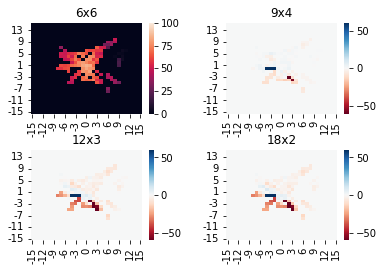

In [276]:
if __name__ == '__main__':
    # main()
    # plot_heatmap()
    plot_heatmap_all_diff()